In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('netflix_titles.csv')

print("İlk 5 Satır:")
print(df.head())

print("\nVeri Seti Bilgileri:")
df.info()

İlk 5 Satır:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24,

In [3]:
print("\nEksik Değer Sayıları:")
print(df.isnull().sum())

# Eksik değerleri "Unknown" ile dolduracağımız sütunlar:
cols_to_fill = ['director', 'cast', 'country', 'date_added', 'rating']

# Belirtilen sütunlardaki NaN değerleri "Unknown" stringi ile doldurun
df[cols_to_fill] = df[cols_to_fill].fillna('Unknown')

# Tüm eksik değerleri tekrar kontrol edin. 'duration' ve 'date_added' gibi sütunlarda hala eksik olabilir,
# ancak bu sütunlar için özel işlem yapacağız.
print("\n'Unknown' ile Doldurulduktan Sonra Eksik Değer Sayıları:")
print(df.isnull().sum())


Eksik Değer Sayıları:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

'Unknown' ile Doldurulduktan Sonra Eksik Değer Sayıları:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        3
listed_in       0
description     0
dtype: int64


In [4]:
# 1. 'duration' sütununu temizlemek ve iki yeni sütun oluşturmak için fonksiyon tanımlayalım.
def clean_duration(row):
    if row['type'] == 'Movie':
        # Filmler için sadece dakika sayısını al ve integer'a çevir
        try:
            return int(row['duration'].replace(' min', ''))
        except:
            return 0  # Hata durumunda 0 döndür
    else:
        # Diziler için sezon sayısını al ve integer'a çevir
        try:
            return int(row['duration'].split(' ')[0])
        except:
            return 0  # Hata durumunda 0 döndür

# Yeni sütunları oluşturun
df['duration_int'] = df.apply(clean_duration, axis=1)

# duration_type sütunu oluşturun (min/season)
df['duration_type'] = df['duration'].apply(lambda x: 'min' if 'min' in str(x) else 'Seasons')

print("\n'duration' Temizliği Sonrası İlk 5 Satır:")
print(df[['type', 'duration', 'duration_int', 'duration_type']].head())


'duration' Temizliği Sonrası İlk 5 Satır:
      type   duration  duration_int duration_type
0    Movie     90 min            90           min
1  TV Show  2 Seasons             2       Seasons
2  TV Show   1 Season             1       Seasons
3  TV Show   1 Season             1       Seasons
4  TV Show  2 Seasons             2       Seasons


/tmp/ipython-input-2834630943.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='type', data=df, palette='viridis')


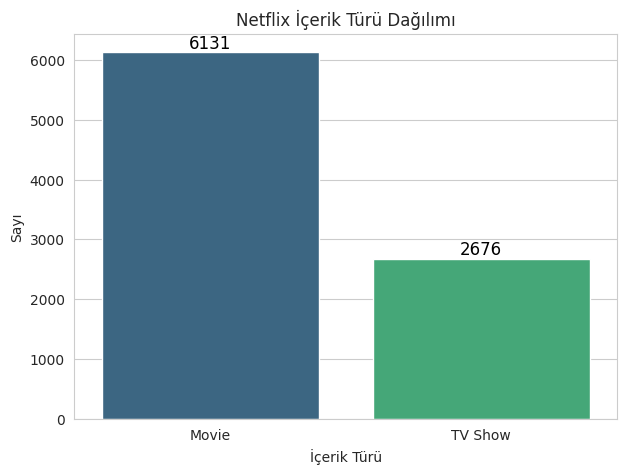

In [6]:
sns.set_style("whitegrid")

# --- 3.1. İçerik Türü Dağılımı (Movie vs. TV Show) ---
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='type', data=df, palette='viridis')
plt.title('Netflix İçerik Türü Dağılımı')
plt.xlabel('İçerik Türü')
plt.ylabel('Sayı')

# Sayıları çubukların üzerine yazdıralım
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(),
            '{:1.0f}'.format(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()

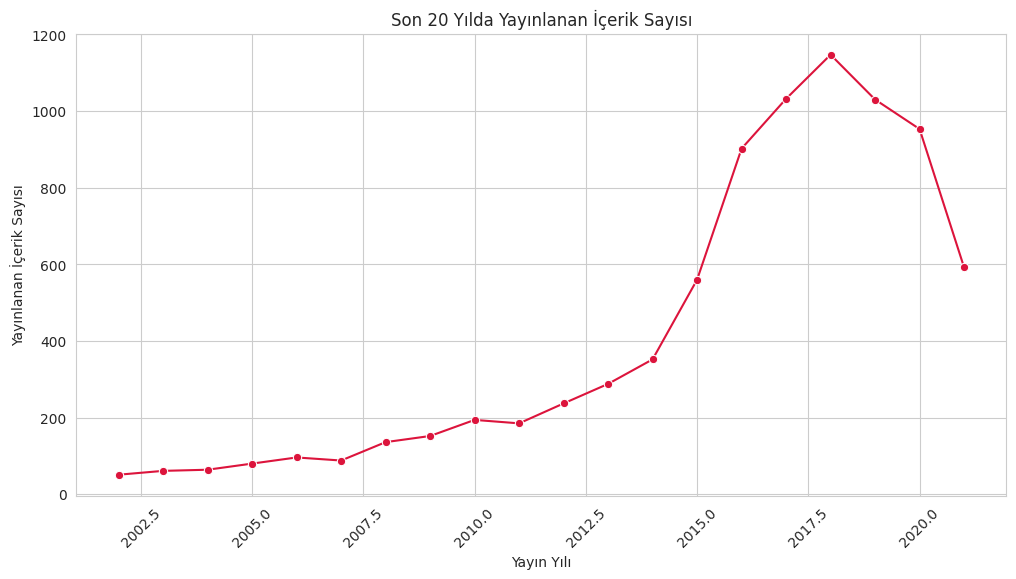

In [7]:
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
release_counts = df['release_year'].value_counts().sort_index().tail(20)

plt.figure(figsize=(12, 6))
sns.lineplot(x=release_counts.index, y=release_counts.values, marker='o', color='crimson')
plt.title('Son 20 Yılda Yayınlanan İçerik Sayısı')
plt.xlabel('Yayın Yılı')
plt.ylabel('Yayınlanan İçerik Sayısı')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipython-input-2453611122.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette='RdPu')


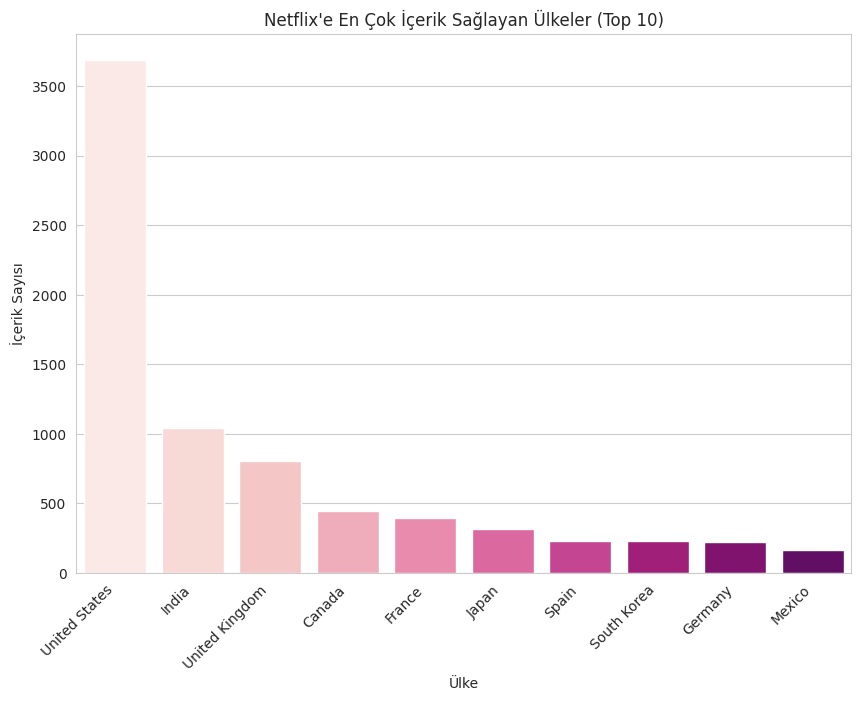

In [8]:
country_counts = df['country'].str.split(', ', expand=True).stack().value_counts()
top_10_countries = country_counts[country_counts.index != 'Unknown'].head(10)

plt.figure(figsize=(10, 7))
sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette='RdPu')
plt.title('Netflix\'e En Çok İçerik Sağlayan Ülkeler (Top 10)')
plt.xlabel('Ülke')
plt.ylabel('İçerik Sayısı')
plt.xticks(rotation=45, ha='right')
plt.show()

/tmp/ipython-input-2871387911.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index, palette='Spectral')


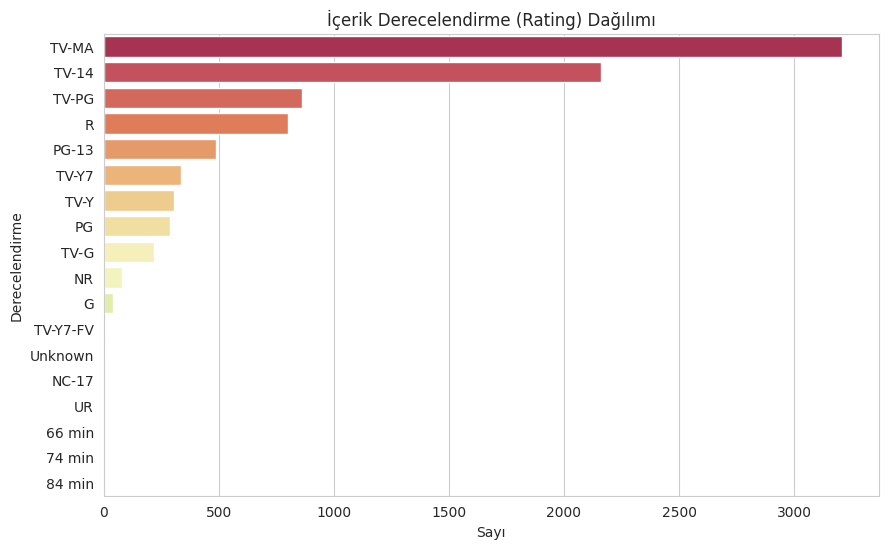

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index, palette='Spectral')
plt.title('İçerik Derecelendirme (Rating) Dağılımı')
plt.xlabel('Sayı')
plt.ylabel('Derecelendirme')
plt.show()

Bu adımda, her içeriğin birden fazla türü olduğu için, bunları ayrı ayrı satırlar halinde ayırarak her bir türün gerçek frekansını bulacağız. Bu, hem Tür Analizinin temelini oluşturacak hem de Öneri Sistemi için veri hazırlayacaktır.

In [10]:
df_genres = df.assign(listed_in=df['listed_in'].str.split(', ')).explode('listed_in')

# Parçalanmış veri setinin ilk birkaç satırını kontrol edin
print("Parçalanmış Genre Veri Setinin İlk 5 Satırı (Türler Genişletildi):")
print(df_genres[['title', 'type', 'listed_in']].head())

Parçalanmış Genre Veri Setinin İlk 5 Satırı (Türler Genişletildi):
                  title     type               listed_in
0  Dick Johnson Is Dead    Movie           Documentaries
1         Blood & Water  TV Show  International TV Shows
1         Blood & Water  TV Show               TV Dramas
1         Blood & Water  TV Show            TV Mysteries
2             Ganglands  TV Show          Crime TV Shows


In [11]:
# listed_in sütununda her bir türün kaç kez geçtiğini sayın
genre_counts = df_genres['listed_in'].value_counts()
top_10_genres = genre_counts.head(10)

print("\nEn Popüler 10 Netflix Türü:")
print(top_10_genres)


En Popüler 10 Netflix Türü:
listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: int64


/tmp/ipython-input-495553903.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='plasma')


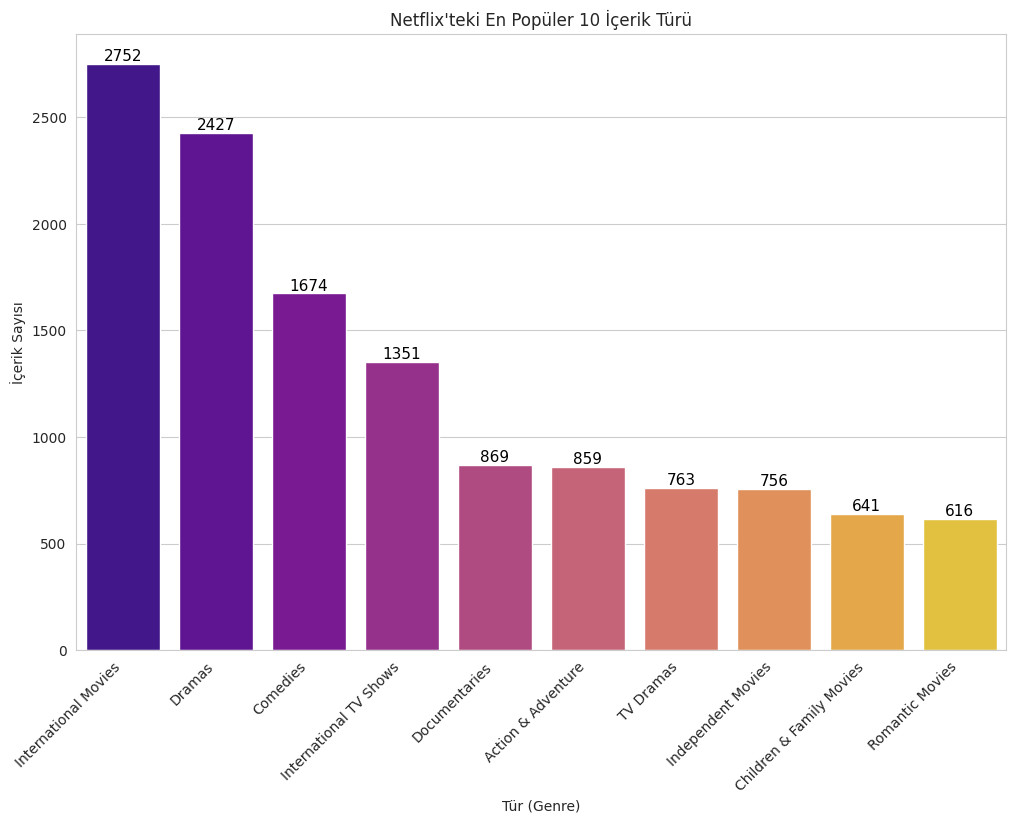

In [12]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='plasma')
plt.title('Netflix\'teki En Popüler 10 İçerik Türü')
plt.xlabel('Tür (Genre)')
plt.ylabel('İçerik Sayısı')
plt.xticks(rotation=45, ha='right')

# Sayıları çubukların üzerine yazdıralım
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(),
            '{:1.0f}'.format(p.get_height()),
            fontsize=11, color='black', ha='center', va='bottom')

plt.show()

Veri temizliği ve tür analizi verilerimiz hazır. Şimdi öğrendiklerimizi uygulamaya koyarak basit bir İçerik Tabanlı Öneri Sistemi denemesi yapalım

In [13]:
# TF-IDF vektörleştiricisi-yalnızca string değerlerle çalışır
df['description'] = df['description'].fillna('')

In [16]:
# stop_words='english': İngilizce'deki "a, the, is, of" gibi anlamsız kelimeleri (durdurma kelimeleri) kaldırmak için kullanılır.
# max_features=20000: En çok geçen 20000 kelimeyi alarak vektör boyutunu sınırlar.
tfidf = TfidfVectorizer(stop_words='english', max_features=20000)

In [17]:
# Veri setindeki tüm açıklamaları öğrenir ve bir TF-IDF matrisine dönüştürür.
tfidf_matrix = tfidf.fit_transform(df['description'])

In [18]:
# Matrisin boyutunu kontrol edin (Satır sayısı, seçilen kelime sayısı)
print(f"TF-IDF Matris Boyutu: {tfidf_matrix.shape}")

TF-IDF Matris Boyutu: (8807, 18895)


In [19]:
# Bu matris, veri setindeki her bir içerik çiftinin benzerlik skorunu tutar.
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [20]:
print(f"Kosinüs Benzerliği Matrisi Boyutu: {cosine_sim.shape}")

Kosinüs Benzerliği Matrisi Boyutu: (8807, 8807)


In [21]:
# Kullanıcının beğendiği bir film adı verildiğinde, benzer filmleri döndürür.

# Başlıkları indekslemek için bir seri oluşturalım
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [22]:
def get_recommendations(title, cosine_sim=cosine_sim, df=df, indices=indices):
    # Başlığın indeksini al
    if title not in indices:
        return f"Hata: '{title}' başlığı veri setinde bulunamadı."

    idx = indices[title]

    # İlgili başlığa ait benzerlik skorlarını al
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Skorları azalan sırada sırala (en benzer en başta)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Kendisini hariç tutarak ilk 10 en benzer içeriğin skorlarını al
    # İlk eleman kendisidir (benzerlik 1.0), bu yüzden 1'den 11'e kadar alıyoruz.
    sim_scores = sim_scores[1:11]

    # İndeksleri al
    movie_indices = [i[0] for i in sim_scores]

    # Benzer içeriklerin başlıklarını döndür
    recommendations = df['title'].iloc[movie_indices]

    # Benzerlik skorlarını da ekleyerek döndür
    scores = [i[1] for i in sim_scores]

    return pd.DataFrame({'Title': recommendations.values, 'Similarity Score': scores})

In [28]:
try:
    print("\n--- 'Taxi Driver' için Öneriler ---")
    recommendations_Driver = get_recommendations('Taxi Driver')
    print(recommendations_Driver)
except:
    pass # Eğer 'Taxi Driver' başlığı veri setinde yoksa hata vermez.

print("\n--- 'Extraction' için Öneriler ---")
recommendations_extraction = get_recommendations('Extraction')
print(recommendations_extraction)


--- 'Taxi Driver' için Öneriler ---
                                 Title  Similarity Score
0                             Diablero          0.221370
1                          Zombie Dumb          0.196326
2                           The Prince          0.169037
3                                Killa          0.156085
4                     Conjuring Spirit          0.150317
5                               Legion          0.149995
6     Khelti Hai Zindagi Aankh Micholi          0.142367
7              Mythily Veendum Varunnu          0.142112
8  We'll Be Right Back After The Break          0.137739
9                      Raja Hindustani          0.135526

--- 'Extraction' için Öneriler ---
                    Title  Similarity Score
0            Act of Valor          0.261946
1                 The 2nd          0.223092
2                Incoming          0.191596
3   The Business of Drugs          0.184965
4  Code Name: The Cleaner          0.167127
5                 Lockout          0